In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 10)


In [2]:
class PipelineStage:
    def __init__(self, next_stage=None):
        self.next = next_stage
        
    def invoke_next(self, intermediate):
        if (self.next):
            return self.next(intermediate)
        else:
            return intermediate
        
    def process(self, intermedate):
        return intermediate
    
    def __call__(self, intermediate):
        return self.invoke_next(self.process(intermediate))

def to_rgb(intermediate):
    layer = intermediate * 255
    return np.dstack((layer, layer, layer))


In [3]:
def visualize_process_stage(orig_img, processed_img, 
                            orig_title='Original image', 
                            processed_title='Processed Image', 
                            orig_cmap=None,
                            processed_cmap=None,
                            output_file=None):
    fig, axes = plt.subplots(1, 2)

    axes[0].imshow(orig_img, orig_cmap)
    axes[0].set_title(orig_title)

    axes[1].imshow(processed_img, processed_cmap)
    axes[1].set_title(processed_title)

    if (output_file):
        fig.savefig(output_file);


# Camera calibration

In [4]:
from glob import glob

def calibration_images():
    calibration_image_files = glob('camera_cal/calibration*.jpg')
    for fn in calibration_image_files:
        img = mpimg.imread(fn)
        yield cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def find_chessboard_corners(images):
    board_size = (9, 6)
    obj_corners = np.array([[x, y, 0] for y in range(board_size[1]) for x in range(board_size[0])],
                          dtype=np.float32)

    obj_points = []
    image_points = []
    for img in calibration_images():
        ret, corners = cv2.findChessboardCorners(img, board_size, None)
        if ret: 
            obj_points.append(obj_corners)
            image_points.append(corners)
    
    return (obj_points, image_points)

def calibrate_camera(obj_points, image_points):
    calibration_image_size = (720, 1280)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        obj_points, image_points, calibration_image_size, None, None)
        
    if ret: 
        return (mtx, dist)
    else:
        raise "Unable to calibrate camera"
        
class CorrectDistortion(PipelineStage):
    mtx = None
    dist = None
    
    @classmethod
    def calibrate(self, calibration_images):
        obj_points, image_points = find_chessboard_corners(calibration_images)
        mtx, dist = calibrate_camera(obj_points, image_points)
        self.mtx = mtx
        self.dist = dist
    
    def process(self, intermediate):
        undistorted = self._undistort_image(intermediate)
        return undistorted
    
    def _undistort_image(self, image):
        return cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
    
CorrectDistortion.calibrate(calibration_images())

# Testing calibration

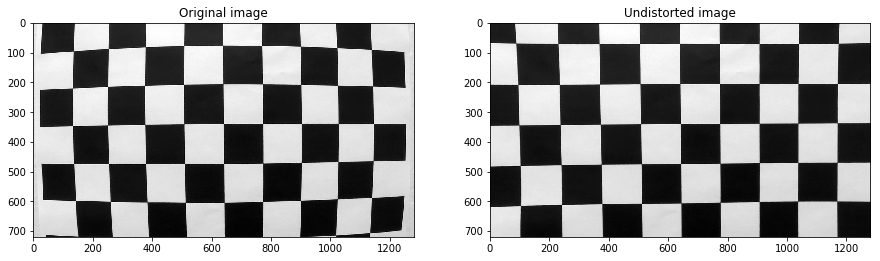

In [5]:
test_image = next(calibration_images())
processor = CorrectDistortion()
visualize_process_stage(test_image, processor(test_image), 
                        processed_title='Undistorted image',
                        orig_cmap='gray', processed_cmap='gray',
                        output_file='output/calibration_test.png')


# Image processing pipeline

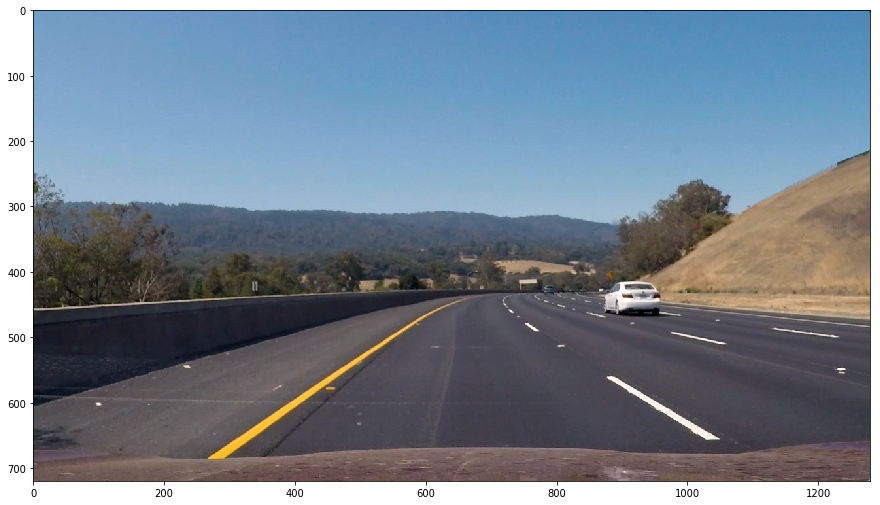

In [6]:
sample_image = mpimg.imread('./test_images/test3.jpg')
plt.imshow(sample_image)

## Correcting distortion

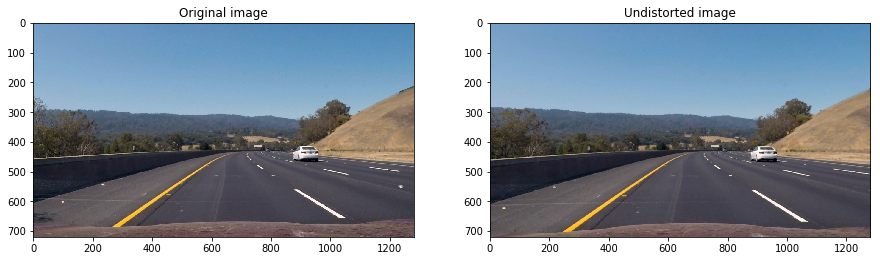

In [7]:
corrector = CorrectDistortion()
processed_image = corrector(sample_image)

visualize_process_stage(sample_image, processed_image, 
                        processed_title='Undistorted image', 
                        output_file='output/undistorted.png')

## Thresholding

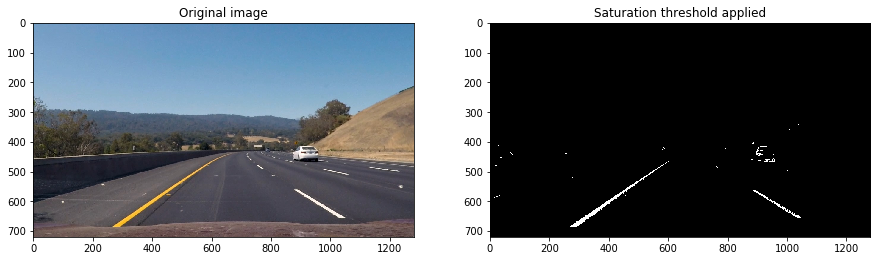

In [8]:
class SaturationThreshold(PipelineStage):
    threshold = (150, 255)
    
    def process(self, intermediate):
        hsl = cv2.cvtColor(intermediate, cv2.COLOR_RGB2HLS)
        sat = hsl[:, :, 2]
        mask = np.zeros_like(sat)
        mask[(sat > self.threshold[0]) & (sat <= self.threshold[1])] = 1
        return mask
        

thresholder = SaturationThreshold()
processed = thresholder(sample_image)
visualize_process_stage(sample_image, thresholder(sample_image),
                        processed_title='Saturation threshold applied', 
                        processed_cmap='gray',
                        output_file='output/saturation_threshold.png')




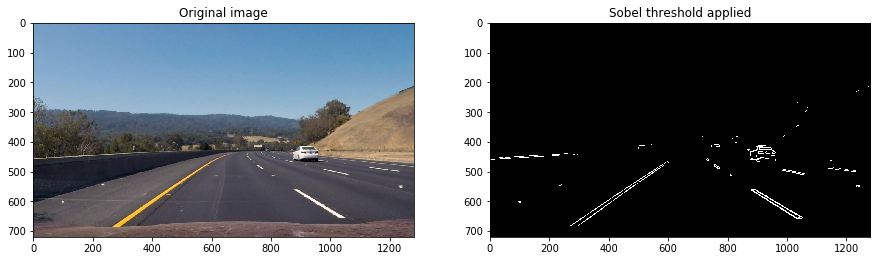

In [9]:
class SobelMagnitudeThreshold(PipelineStage):
    threshold = (100, 255)
    kernel = 13
    
    def process(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=self.kernel)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=self.kernel)
        sobel_mag = np.sqrt(np.square(sobel_x) + np.square(sobel_y))
        sobel_scaled = np.uint8(255 * sobel_mag / np.max(sobel_mag))
        mask = np.zeros_like(sobel_scaled)
        
        mask[(sobel_scaled > self.threshold[0]) & (sobel_scaled <= self.threshold[1])] = 1
        return mask
        

thresholder = SobelMagnitudeThreshold()
visualize_process_stage(sample_image, thresholder(sample_image),
                        processed_title='Sobel threshold applied', 
                        processed_cmap='gray',
                        output_file='output/sobel_threshold.png')

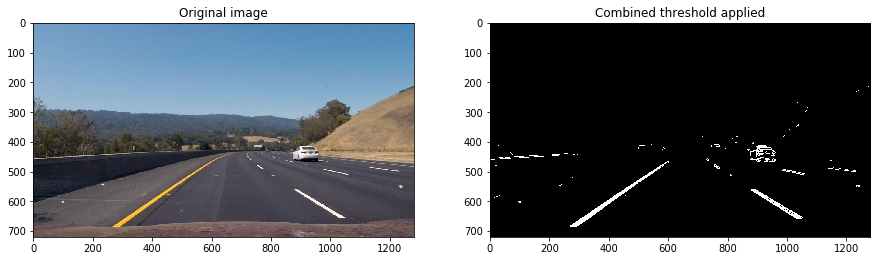

In [10]:
class Or(PipelineStage):
    def __init__(self, t1, t2, next_stage=None):
        super().__init__(next_stage)
        self.t1 = t1
        self.t2 = t2
        
    def process(self, image):
        m1 = self.t1(image)
        m2 = self.t2(image)
        
        mask = np.zeros(image.shape[0:2])
        mask[(m1 == 1) | (m2 == 1)] = 1
        return mask
    
stage = Or(SaturationThreshold(), SobelMagnitudeThreshold())

visualize_process_stage(sample_image, stage(sample_image),
                        processed_title='Combined threshold applied', 
                        processed_cmap='gray',
                        output_file='output/combined_threshold.png')

## Perspective transform

In [11]:
class PerspectiveTransform(PipelineStage):
    image_points = np.array([(245, 685), (580, 460), (704, 460), (1053, 667)], dtype=np.float32)
    object_points = np.array([(245, 720), (245, 0), (1053, 0), (1053, 720)], dtype=np.float32)
    warp_mtx = cv2.getPerspectiveTransform(image_points, object_points)
    unwarp_mtx = cv2.getPerspectiveTransform(object_points, image_points)
    
    def apply(self, image, mtx):
        img_size = (image.shape[1], image.shape[0])
        warped = cv2.warpPerspective(image, mtx, img_size, flags=cv2.INTER_LINEAR)
        return warped
    
class UnwarpPerspective(PerspectiveTransform):
    def process(self, image):
        return self.apply(image, self.warp_mtx)
    
class WarpPerspective(PerspectiveTransform):
    def process(self, image):
        return self.apply(image, self.unwarp_mtx)


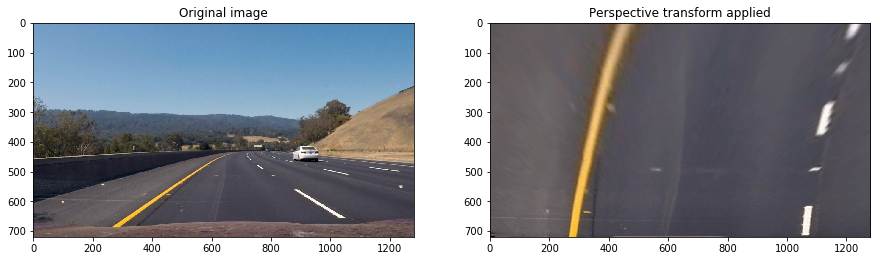

In [12]:
transform = UnwarpPerspective()

warped = transform(sample_image)
visualize_process_stage(sample_image, warped, processed_title='Perspective transform applied', 
                        output_file='output/perspective_transform.png')


## Finding lane lines

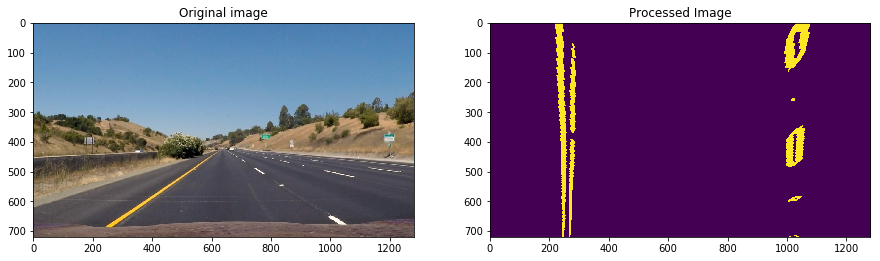

In [13]:
pipe = CorrectDistortion(SobelMagnitudeThreshold(UnwarpPerspective()))
sample_image = mpimg.imread('./test_images/straight_lines1.jpg')
processed = pipe(sample_image)

visualize_process_stage(sample_image, processed)

## Convolutional approach

In [14]:
class NoPeak(Exception):
    pass

class Convolver:
    window_width = 50
    window_height = 80
    margin = 100
    window = np.ones(window_width)
    
    def __init__(self, image):
        self.image = image
        self.image_width = image.shape[1]
        self.image_height = image.shape[0]
        
    def find_initial_centroids(self):
        lower_bound = self.image_height
        upper_bound = int(self.image_height / 2)
        pixels = self.image[upper_bound:lower_bound, :]
        pixel_sum = np.sum(pixels, axis=0)
        conv_signal = np.convolve(pixel_sum, self.window)    
        
        middle = len(conv_signal) // 2
        left_peak = self.find_peak(conv_signal[:middle]) - self.window_width // 2
        right_peak = self.find_peak(conv_signal[middle:]) + middle - self.window_width // 2
        return left_peak, right_peak
    
    def find_peak(self, array):
        peak = np.argmax(array)
        if peak == 0:
            raise NoPeak("No peak found", self.image)
        return peak
        
    def slice_image(self):
        layers = int(self.image_height / self.window_height)
        for layer in range(layers):
            lower_bound = self.image_height - (layer + 1) * self.window_height
            upper_bound = self.image_height - layer * self.window_height
            layer_pixels = self.image[lower_bound:upper_bound, :]
            yield layer_pixels
            
    
            
    def convolve_by_layer(self):
        for layer in self.slice_image():
            layer_sum = np.sum(layer, axis=0)
            conv_signal = np.convolve(layer_sum, self.window)
            yield conv_signal

In [15]:
class DrawDetectedLines(PipelineStage):
    def process(self, image):
        conv = Convolver(image)
        left, right = conv.find_initial_centroids()
        
        lines_img = np.zeros((image.shape[0], image.shape[1], 3), np.uint8)
        self.draw_lane(lines_img, left, right)
        return lines_img
    
    def draw_lane(self, image, left, right):
        upper_left = (left, 0)
        lower_right = (right, image.shape[0])
        self.fill_rect(image, upper_left, lower_right)
    
    def fill_rect(self, image, pt1, pt2):
        cv2.rectangle(image, pt1, pt2, color=(255, 0, 0), thickness=-1)
        

# Video processing pipeline

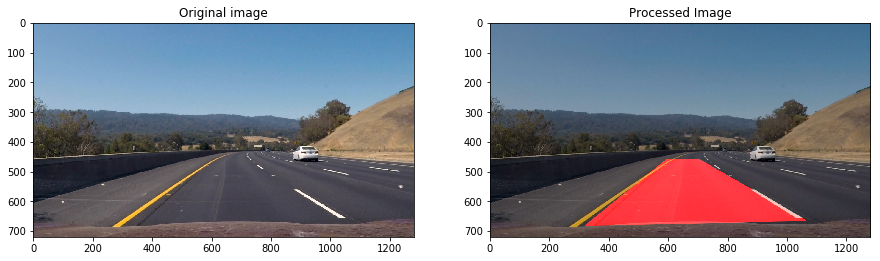

In [17]:
import os.path as path
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def display_video(video_file):
    return HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_file))

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def process_video(filename, processor):
    clip = VideoFileClip(filename)
    processed = clip.fl_image(processor)
    
    output_base = path.basename(filename)
    output_file = path.join('output', output_base)
    processed.write_videofile(output_file, audio=False)
    return output_file

def process_frame(line_detector):
    warp = WarpPerspective()
    
    def _fn(video_frame):
        try:
            lines_img = line_detector(video_frame)
            combined_image = weighted_img(warp(lines_img), video_frame)
            return combined_image
        except NoPeak:
            raise Exception('No peak in image', video_frame)
    
    return _fn

line_detector = process_frame(
    CorrectDistortion(
        Or(SobelMagnitudeThreshold(), SaturationThreshold(), 
              UnwarpPerspective(
                    DrawDetectedLines()))))



sample_image = plt.imread('./test_images/test3.jpg')
visualize_process_stage(sample_image, line_detector(sample_image))

In [ ]:
input_file = './project_video.mp4'
problem_frame = None
try:
    process_video(input_file, line_detector)
except Exception as ex:
    problem_frame = ex.args
    print("Exception!")


In [ ]:
display_video(output)

In [18]:
video_processor = CorrectDistortion(
        Or(SobelMagnitudeThreshold(), SaturationThreshold(), 
           UnwarpPerspective(to_rgb)))

input_file = './project_video.mp4'
output = process_video(input_file, video_processor)
display_video(output)

[MoviePy] >>>> Building video output/project_video.mp4
[MoviePy] Writing video output/project_video.mp4


100%|█████████▉| 1260/1261 [02:31<00:00,  9.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_video.mp4 

